# Модель DeepLabV3

In [25]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import numpy as np
from pathlib import Path
from PIL import Image
import os
from typing import Dict, Any
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.images = sorted(list(self.image_dir.glob("*.png"))) 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.mask_dir / img_path.name  # Маска с таким же именем

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))  # Маска в градациях серого
        mask = (mask > 0).astype(np.float32)  # Бинарная маска (0 или 1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
        
        if len(mask.shape) == 2:  # If mask is (256, 256), add channel dimension
            mask = mask[None, ...]  # Shape: (1, 256, 256)

        return image, mask

# Аугментация
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

In [ ]:
train_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\train\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\train\masks',
    transform=train_transform
)

valid_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\val\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\val\masks',
    transform=val_transform
)

test_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\test\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\test\masks',
    transform=val_transform
)

train_loader = DataLoader(train_dataset,
                                batch_size=4,
                                shuffle=True
                                )
valid_loader = DataLoader(valid_dataset,
                                batch_size=4
                                )
test_loader = DataLoader(test_dataset,
                                batch_size=4
                                )

images, masks = next(iter(train_loader))
print("Размерность изображений:", images.shape)
print("Размерность масок:", masks.shape)
print("Тип изображений:", images.dtype)
print("Тип масок:", masks.dtype)
print("Классы:", masks.unique())

Размерность изображений: torch.Size([4, 3, 256, 256])
Размерность масок: torch.Size([4, 1, 256, 256])
Тип изображений: torch.float32
Тип масок: torch.float32
Классы: tensor([0., 1.])


In [26]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchmetrics
from typing import Dict, Any


class DeepLabV3PlusLightning(pl.LightningModule):
    def __init__(self, encoder_name="resnet50", learning_rate=1e-3, encoder_weights='imagenet'):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.criterion = nn.BCEWithLogitsLoss()  # Лосс для бинарной сегментации
        self.lr = learning_rate
        
        # Инициализация метрик
        self.train_iou = torchmetrics.JaccardIndex(task="binary", num_classes=2)
        self.val_iou = torchmetrics.JaccardIndex(task="binary", num_classes=2)
        self.test_iou = torchmetrics.JaccardIndex(task="binary", num_classes=2)
        
        self.train_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.val_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.test_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        
        self.train_precision = torchmetrics.Precision(task="binary", num_classes=2)
        self.val_precision = torchmetrics.Precision(task="binary", num_classes=2)
        self.test_precision = torchmetrics.Precision(task="binary", num_classes=2)
        
        self.train_recall = torchmetrics.Recall(task="binary", num_classes=2)
        self.val_recall = torchmetrics.Recall(task="binary", num_classes=2)
        self.test_recall = torchmetrics.Recall(task="binary", num_classes=2)
        
        self.train_f1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.val_f1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.test_f1 = torchmetrics.F1Score(task="binary", num_classes=2)

    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch, stage):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.float())
        
        # Применяем сигмоиду и порог для получения бинарных предсказаний
        preds = torch.sigmoid(outputs) > 0.5
        
        metrics = {
            f"{stage}_loss": loss,
            f"{stage}_iou": getattr(self, f"{stage}_iou")(preds, masks.float()),
            f"{stage}_accuracy": getattr(self, f"{stage}_accuracy")(preds, masks.float()),
            f"{stage}_precision": getattr(self, f"{stage}_precision")(preds, masks.float()),
            f"{stage}_recall": getattr(self, f"{stage}_recall")(preds, masks.float()),
            f"{stage}_f1": getattr(self, f"{stage}_f1")(preds, masks.float()),
        }
        
        # Логируем метрики
        self.log_dict(metrics, prog_bar=True if stage == "val" else False)
        
        return loss if stage != "test" else metrics

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, "test")
    
    def on_train_epoch_end(self):
        # Сбрасываем метрики в конце эпохи
        self.train_iou.reset()
        self.train_accuracy.reset()
        self.train_precision.reset()
        self.train_recall.reset()
        self.train_f1.reset()
    
    def on_validation_epoch_end(self):
        # Сбрасываем метрики в конце эпохи
        self.val_iou.reset()
        self.val_accuracy.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()
    
    def on_test_epoch_end(self):
        # Сбрасываем метрики в конце эпохи
        self.test_iou.reset()
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()

    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            patience=3, 
            factor=0.5,
            verbose=True, # type: ignore
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            }
        }

In [28]:
# Инициализация модели
model = DeepLabV3PlusLightning(encoder_name="resnet50", learning_rate=1e-3)


# Настройка логгера TensorBoard
logger = TensorBoardLogger(save_dir="../logs/", name="DeepLab_segmentation")

# Настройка callback для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  
    dirpath="../data/checkpoints/", 
    filename="deeplab-{epoch:02d}-{val_loss:.2f}",  
    save_top_k=1,
    save_last=True, 
    mode="min"  
)

# Инициализация тренера
trainer = pl.Trainer(
    max_epochs=60,  # Количество эпох
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Использовать GPU, если доступно
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:

# Дообучение модели

checkpoint_path = "../data/checkpoints/deeplab-epoch=38-val_loss=0.19.ckpt"

trainer.fit(model, train_loader, valid_loader, ckpt_path=checkpoint_path)




In [ ]:
# Тестирование модели
trainer.test(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 234/234 [00:13<00:00, 17.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9233434200286865     │
│          test_f1          │    0.6085978746414185     │
│         test_iou          │    0.46161898970603943    │
│         test_loss         │    0.22596703469753265    │
│      test_precision       │    0.7162193059921265     │
│        test_recall        │    0.5733767747879028     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22596703469753265,
  'test_iou': 0.46161898970603943,
  'test_accuracy': 0.9233434200286865,
  'test_precision': 0.7162193059921265,
  'test_recall': 0.5733767747879028,
  'test_f1': 0.6085978746414185}]

# Инференс

In [ ]:
import glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

# Загрузка модели из чекпоинта
model = DeepLabV3PlusLightning.load_from_checkpoint(r"D:\URFU\VKR\Ind_pract\dissert\data\checkpoints\last.ckpt")
model.eval()

# Получение файлов изображений
input_path = r"D:\URFU\VKR\Ind_pract\dissert\input"
files = glob.glob(os.path.join(input_path, "*"))
files = [file for file in files if os.path.isfile(file)]

# Получение файлов контрольных масок
mask_path = r"D:\URFU\VKR\Ind_pract\dissert\input\masks"
mask_files = glob.glob(os.path.join(mask_path, "*"))
mask_files = [file for file in mask_files if os.path.isfile(file)]

assert len(files) == len(mask_files), "Количество изображений и масок не совпадает"

# Формирование датасета
class InferenceDataset(Dataset):
    def __init__(self, image_paths, mask_paths): 
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  
        mask = np.array(mask)  
        mask = (mask > 0).astype(np.float32)  

        image = self.transform(image)
        mask = torch.tensor(mask).float()  

        return image, mask 

In [ ]:
# Загрузка датасета
test_dataset = InferenceDataset(image_paths=files, mask_paths=mask_files)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Списки масок и изображений
all_masks = []
all_preds = []


for batch in test_loader:
    images, masks = batch
    with torch.no_grad():
        outputs = model(images) 
    
    # Преобразование предсказаний в бинарную маску
    probs = torch.sigmoid(outputs)  
    preds = (probs > 0.5).float().squeeze().cpu().numpy()
    
    # Сохранение для метрик
    all_preds.append(preds)
    all_masks.append(masks.numpy())

y_true = np.concatenate([m.ravel() for m in all_masks]).astype(int)
y_pred = np.concatenate([p.ravel() for p in all_preds]).astype(int)

# Метрики
accuracy = accuracy_score(y_true, y_pred)
iou = jaccard_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"IoU: {iou:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9141
IoU: 0.6359
F1-score: 0.7775


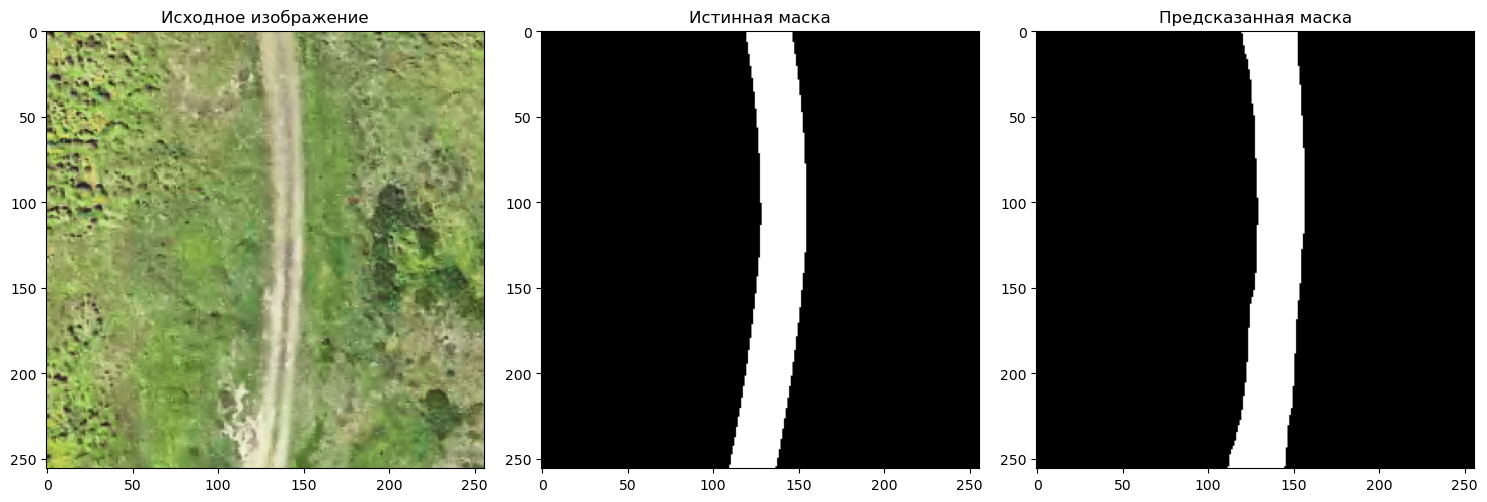

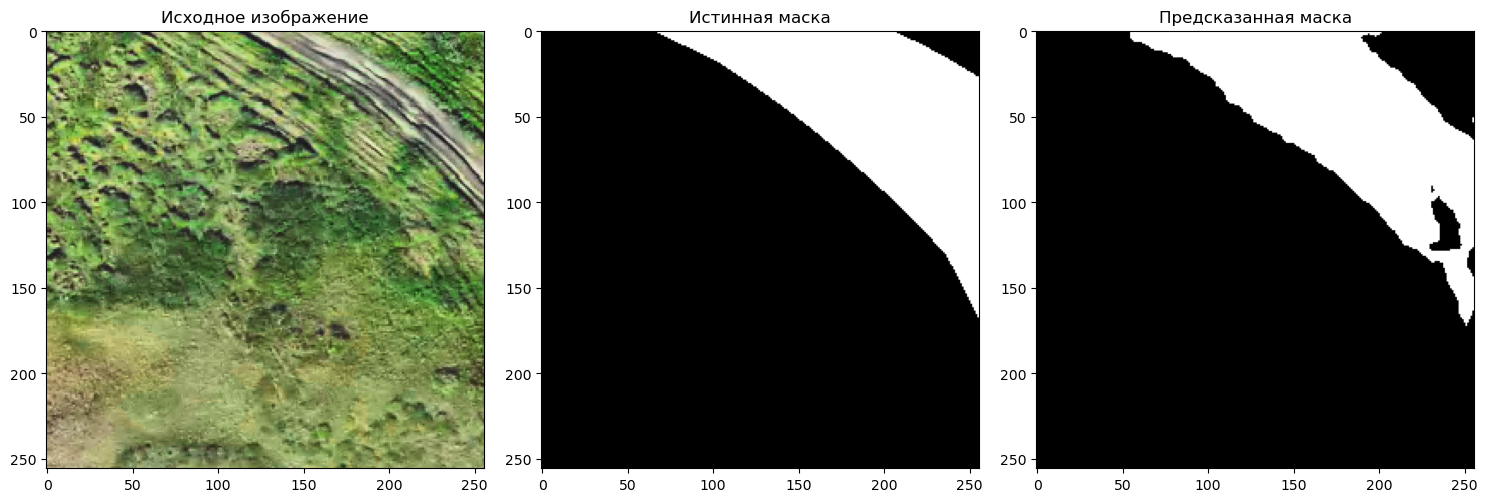

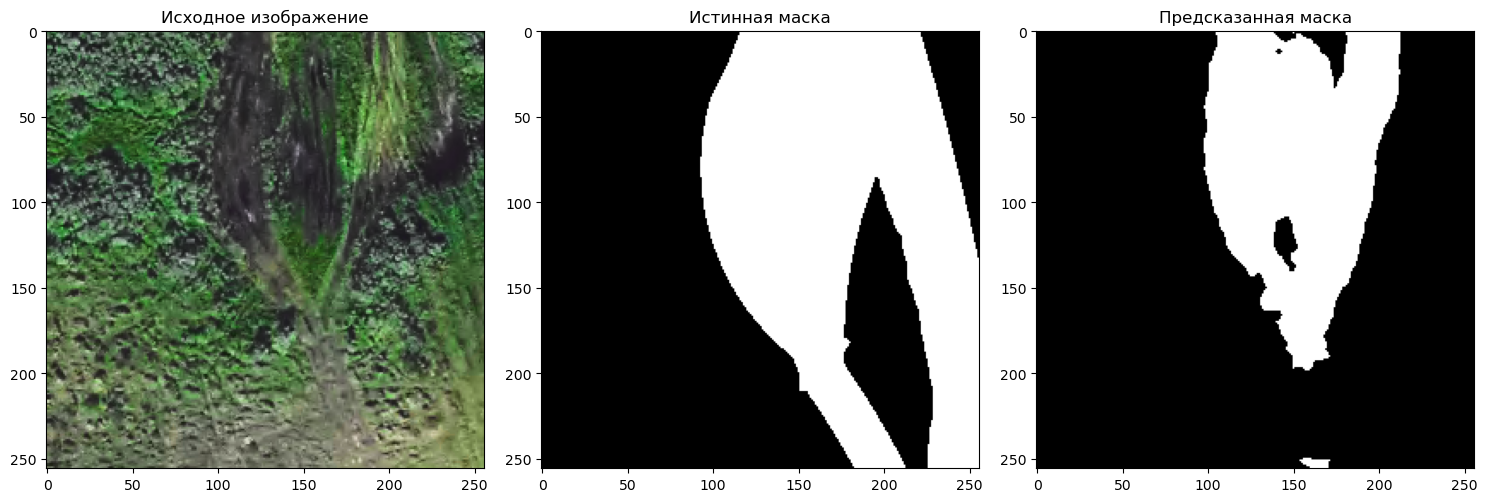

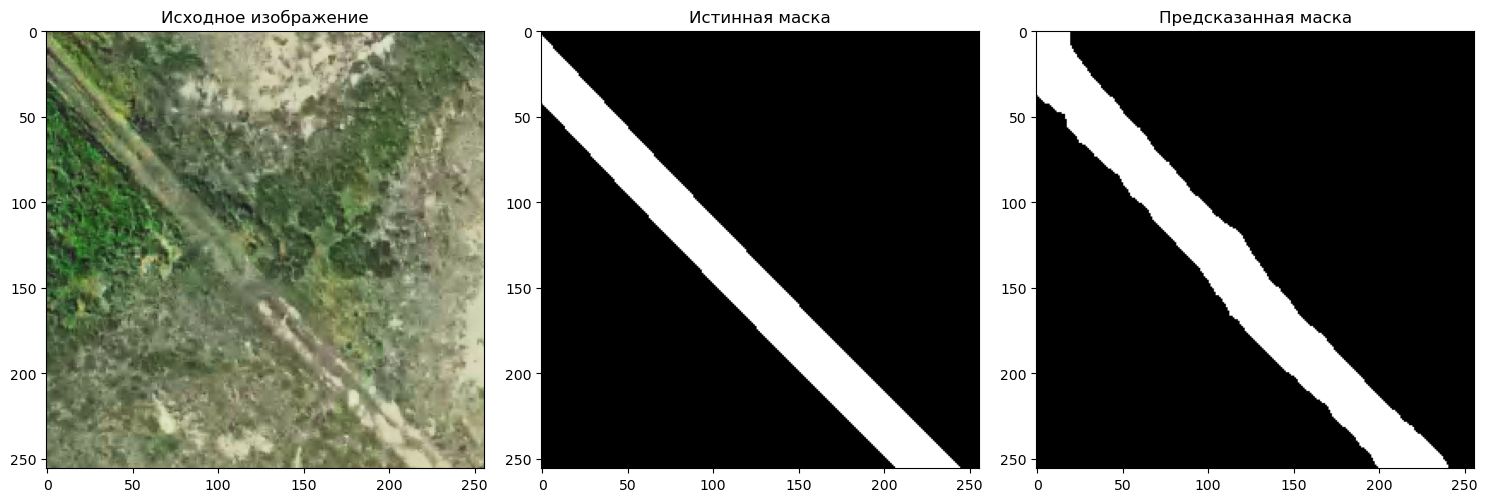

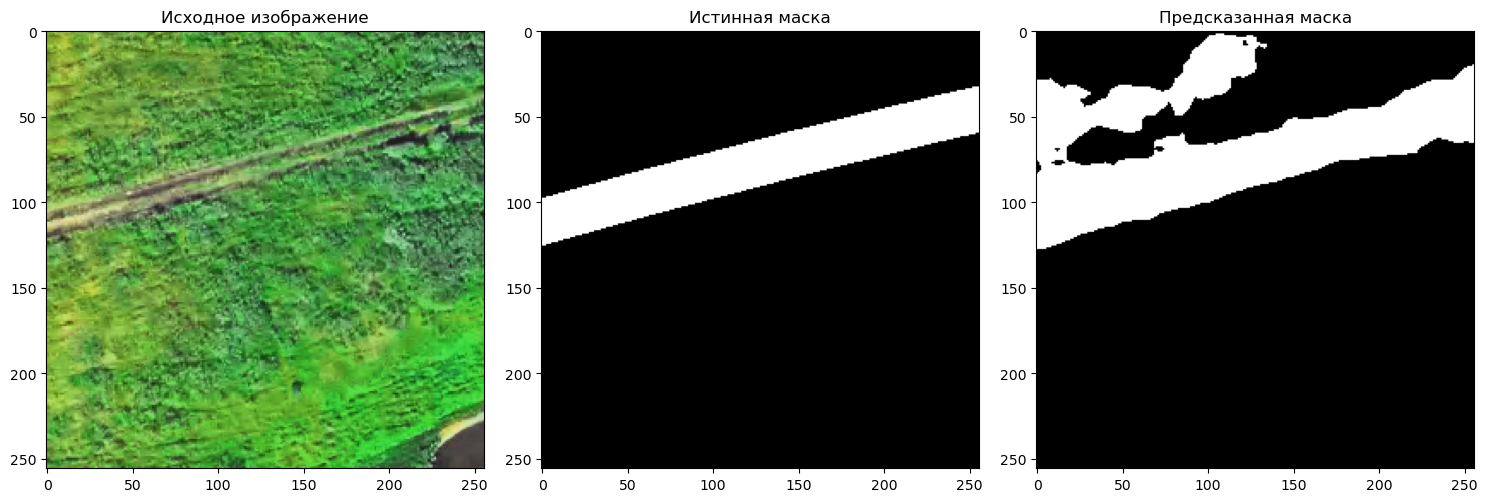

In [ ]:
# Вывод полученных изображений
num_samples = min(5, len(all_masks)) 

for i in range(num_samples):
    image_path = files[i]
    true_mask = all_masks[i][0] 
    pred_mask = all_preds[i]   

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    

    ax[0].imshow(Image.open(image_path))
    ax[0].set_title("Исходное изображение")
    

    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title("Истинная маска")
    

    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title("Предсказанная маска")
    
    plt.tight_layout()
    plt.show()